# 성능개선 기법 실습


# 모듈 정의


## train.py

-   모델 학습과 검증 함수 정의


In [1]:
import os

os.makedirs("module", exist_ok=True)

In [2]:
%%writefile module/train.py

import torch
import time

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() 
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_steps
        test_accuracy /= size
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    Args:
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    Returns:
        tuple: (loss, accuracy)
    """
    model.to(device)
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_steps = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_steps
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    Args:
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    
    Returns:
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()
    size = len(dataloader.dataset) 

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, save_best_model=True, 
        save_model_path=None, early_stopping=True, patience=10, device='cpu',  mode:"binary or multi"='binary',
        lr_scheduler=None):
    """
    모델을 학습시키는 함수

    Args:
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler: Learning Rate Scheduler 객체. default: None, Epoch 단위로 LR 를 변경.
    
    Returns:
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, device=device, mode=mode)
        ############ 1 epoch 학습 종료 -> LR 를 변경 ###########
        if lr_scheduler is not None:
            current_lr = lr_scheduler.get_last_lr()[0]  # log용
            lr_scheduler.step()
            new_lr = lr_scheduler.get_last_lr()[0] # log용
            if current_lr != new_lr: # LR가 변경되었으면
                print(f">>>>>>Learning Rate가 {current_lr}에서 {new_lr}로 변경됨<<<<<<")

        
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save:
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: 
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Writing module/train.py


## data.py

-   dataset 생성 함수 제공 모듈


In [3]:
%%writefile module/data.py

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    Args:
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    
    Returns:
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Writing module/data.py


## utils.py


In [4]:
%%writefile module/utils.py
# 학습 결과를 시각화하는 함수.
import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_accuracy_list, valid_loss_list, valid_accuracy_list):
    """epoch별 학습 결과를 시각화하는 함수
    epoch별 loss와 accuracy를 시각화한다.

    Args:
        train_loss_list (list): Epoch별 train loss
        train_accuracy_list (list): Epoch별 train accuracy
        valid_loss_list (list): Epoch별 validation loss
        valid_accuracy_list (list): Epoch별 validation accuracy
    """
    epoch = len(train_loss_list)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(epoch), train_loss_list, label="train loss")
    plt.plot(range(epoch), valid_loss_list, label="validation loss")
    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(epoch), train_accuracy_list, label="train accuracy")
    plt.plot(range(epoch), valid_accuracy_list, label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid(True, linestyle=':')
    plt.legend()

    plt.tight_layout()
    plt.show()

Writing module/utils.py


## Import

In [1]:
import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module.data import load_mnist_dataset, load_fashion_mnist_dataset
from module.utils import plot_fit_result

## 하이퍼파라미터, 변수 정의


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
root_data_path = "datasets"

epochs = 100
batch_size = 256
lr = 0.001

# Data 준비

## mnist 데이터 로딩


In [7]:
train_loader = load_mnist_dataset(root_data_path, batch_size)
test_loader = load_mnist_dataset(root_data_path, batch_size, False)

## Fashion Mnist
# train_loader = load_fashion_mnist_dataset(root_data_path, batch_size)
# test_loader = load_fashion_mnist_dataset(root_data_path, batch_size, False)

In [8]:
classes = train_loader.dataset.classes
class_to_idx = train_loader.dataset.class_to_idx

# 모델의 크기 변경에 따른 성능변화
## 작은 모델

In [4]:
class SmallModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lr = nn.Linear(28*28, 10) # 입력 -> 출력
    
    def forward(self, X):
        X = nn.Flatten()(X)
        out = self.lr(X)
        return out
    

In [10]:
small_model = SmallModel().to(device)
summary(small_model, (100, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
SmallModel                               [100, 10]                 --
├─Linear: 1-1                            [100, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.79
Input size (MB): 0.31
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.35

In [11]:
loss_fn = nn.CrossEntropyLoss() # 다중분류의 loss 함수
optimizer = torch.optim.Adam(small_model.parameters(), lr=lr)

In [12]:
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = fit(
    train_loader,
    test_loader,
    small_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.48306 Train Accucracy: 0.87998 || Validation Loss: 0.45969 Validation Accuracy: 0.88810
Epoch[2/100] - Train loss: 0.37860 Train Accucracy: 0.90013 || Validation Loss: 0.35989 Validation Accuracy: 0.90770
Epoch[3/100] - Train loss: 0.33880 Train Accucracy: 0.90885 || Validation Loss: 0.32417 Validation Accuracy: 0.91150
Epoch[4/100] - Train loss: 0.31624 Train Accucracy: 0.91360 || Validation Loss: 0.30253 Validation Accuracy: 0.91670
Epoch[5/100] - Train loss: 0.30218 Train Accucracy: 0.91687 || Validation Loss: 0.29141 Validation Accuracy: 0.91880
Epoch[6/100] - Train loss: 0.29249 Train Accucracy: 0.91995 || Validation Loss: 0.28501 Validation Accuracy: 0.92060
Epoch[7/100] - Train loss: 0.28505 Train Accucracy: 0.92067 || Validation Loss: 0.27884 Validation Accuracy: 0.92210
Epoch[8/100] - Train loss: 0.27951 Train Accucracy: 0.92255 || Validation Loss: 0.27352 Validation Accuracy: 0.92340
Epoch[9/100] - Train loss: 0.27422 Train Accucracy: 0.92368 || V

## 큰모델

In [16]:
# nn.Sequential() -> layer block: 레이어 함수들을 묶어놓은 블록

s = nn.Sequential(
    nn.Linear(10, 20),
    nn.ReLU(),
    nn.Linear(20, 30),
    nn.ReLU()
)

i = torch.randn(5, 10, dtype=torch.float32)
o = s(i)
print(o.shape)
o

torch.Size([5, 30])


tensor([[0.0000e+00, 0.0000e+00, 4.0390e-01, 1.2925e-01, 0.0000e+00, 0.0000e+00,
         1.4662e-02, 1.0142e-01, 0.0000e+00, 4.6530e-01, 0.0000e+00, 2.6794e-01,
         5.6710e-02, 1.9376e-01, 0.0000e+00, 0.0000e+00, 1.4133e-02, 0.0000e+00,
         1.9933e-01, 5.5137e-01, 0.0000e+00, 4.8418e-01, 1.6650e-01, 5.1021e-01,
         1.4910e-01, 1.0500e-01, 1.5454e-01, 0.0000e+00, 0.0000e+00, 7.7510e-03],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.6125e-01, 4.9663e-02, 0.0000e+00,
         2.0409e-01, 0.0000e+00, 0.0000e+00, 3.0205e-01, 1.7689e-02, 3.4484e-01,
         4.8291e-01, 0.0000e+00, 0.0000e+00, 4.5987e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.5681e-01, 0.0000e+00, 4.9704e-01, 0.0000e+00, 3.6392e-01,
         0.0000e+00, 1.9177e-01, 5.0551e-02, 8.9630e-02, 0.0000e+00, 3.1958e-01],
        [0.0000e+00, 0.0000e+00, 3.8851e-01, 1.3873e-01, 0.0000e+00, 0.0000e+00,
         3.4975e-01, 3.2900e-01, 1.6214e-01, 6.0074e-02, 0.0000e+00, 2.0560e-01,
         2.1863e-01, 0.000

In [18]:
class BigModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU())
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

In [19]:
big_model = BigModel().to(device)
summary(big_model, (100, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
BigModel                                 [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-4                       [100, 1024]               2,098,176
│    └─ReLU: 2-5                         [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-6                       [100, 512]                524,800
│    └─ReLU: 2-7                         [100, 512]                --
├─Sequential: 1-4                        [100, 256]                --
│    └─Linear: 2-8                       [100, 256]               

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=lr)

In [22]:
train_loss_list2, train_acc_list2, valid_loss_list2, valid_acc_list2 = fit(
    train_loader, test_loader,
    big_model,
    loss_fn,
    optimizer,
    epochs,
    patience=5,
    save_best_model=False,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.09345 Train Accucracy: 0.97285 || Validation Loss: 0.11487 Validation Accuracy: 0.96620
Epoch[2/100] - Train loss: 0.06420 Train Accucracy: 0.98165 || Validation Loss: 0.10549 Validation Accuracy: 0.96930
Epoch[3/100] - Train loss: 0.04947 Train Accucracy: 0.98532 || Validation Loss: 0.08949 Validation Accuracy: 0.97450
Epoch[4/100] - Train loss: 0.03384 Train Accucracy: 0.99028 || Validation Loss: 0.08217 Validation Accuracy: 0.97740
Epoch[5/100] - Train loss: 0.02671 Train Accucracy: 0.99205 || Validation Loss: 0.07911 Validation Accuracy: 0.97730
Epoch[6/100] - Train loss: 0.02759 Train Accucracy: 0.99197 || Validation Loss: 0.09153 Validation Accuracy: 0.97610
Epoch[7/100] - Train loss: 0.02931 Train Accucracy: 0.99155 || Validation Loss: 0.10001 Validation Accuracy: 0.97570
Epoch[8/100] - Train loss: 0.03606 Train Accucracy: 0.98973 || Validation Loss: 0.11231 Validation Accuracy: 0.97340
Epoch[9/100] - Train loss: 0.01387 Train Accucracy: 0.99600 || V

# Dropout 예제

-   dropout 각 레이어에 적용
    -   dropout은 nn.Dropout 객체를 사용
    -   객체 생성시 dropout_rate 설정: 0.2 ~ 0.5
    -   Drop시킬 노드를 가진 Layer 뒤에 추가한다.


In [23]:
class DropoutModel(nn.Module):

    def __init__(self, drop_rate=0.2):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

In [24]:
dout_model = DropoutModel(drop_rate=0.5).to(device)
summary(dout_model, (100, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [100, 10]                 --
├─Sequential: 1-1                        [100, 2048]               --
│    └─Flatten: 2-1                      [100, 784]                --
│    └─Linear: 2-2                       [100, 2048]               1,607,680
│    └─ReLU: 2-3                         [100, 2048]               --
│    └─Dropout: 2-4                      [100, 2048]               --
├─Sequential: 1-2                        [100, 1024]               --
│    └─Linear: 2-5                       [100, 1024]               2,098,176
│    └─ReLU: 2-6                         [100, 1024]               --
│    └─Dropout: 2-7                      [100, 1024]               --
├─Sequential: 1-3                        [100, 512]                --
│    └─Linear: 2-8                       [100, 512]                524,800
│    └─ReLU: 2-9                         [100, 512]               

In [25]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dout_model.parameters(), lr=lr)

In [26]:
train_loss_list3, train_acc_list3, valid_loss_list3, valid_acc_list3 = fit(
    train_loader, test_loader,
    dout_model,
    loss_fn,
    optimizer,
    epochs,
    save_best_model=False,
    patience=5,
    device=device,
    mode='multi'
)

Epoch[1/100] - Train loss: 0.79046 Train Accucracy: 0.61102 || Validation Loss: 0.78956 Validation Accuracy: 0.61090
Epoch[2/100] - Train loss: 0.47743 Train Accucracy: 0.77647 || Validation Loss: 0.49547 Validation Accuracy: 0.77050
Epoch[3/100] - Train loss: 0.33341 Train Accucracy: 0.89497 || Validation Loss: 0.37309 Validation Accuracy: 0.88730
Epoch[4/100] - Train loss: 0.25506 Train Accucracy: 0.94908 || Validation Loss: 0.30862 Validation Accuracy: 0.94220
Epoch[5/100] - Train loss: 0.22485 Train Accucracy: 0.94593 || Validation Loss: 0.26772 Validation Accuracy: 0.93900
Epoch[6/100] - Train loss: 0.17732 Train Accucracy: 0.96062 || Validation Loss: 0.23918 Validation Accuracy: 0.95180
Epoch[7/100] - Train loss: 0.15612 Train Accucracy: 0.96270 || Validation Loss: 0.20895 Validation Accuracy: 0.95680
Epoch[8/100] - Train loss: 0.12588 Train Accucracy: 0.97300 || Validation Loss: 0.20976 Validation Accuracy: 0.96360
Epoch[9/100] - Train loss: 0.12030 Train Accucracy: 0.97185 || V

# Batch Normalization

- Dense 와 Activation 사이에 정의한다.


In [2]:
# nn.BatchNorm1d(입력 feature 개수)
# Linear -> BatchNorm -> ReLU(Activation)
# Linear -> BatchNorm -> ReLU(Activation) -> Dropout

class BatchNormModel(nn.Module):

    def __init__(self, drop_rate=0.2):
        super().__init__()
        self.b1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 2048), nn.BatchNorm1d(2048), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b2 = nn.Sequential(nn.Linear(2048, 1024), nn.BatchNorm1d(1024), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b3 = nn.Sequential(nn.Linear(1024, 512), nn.BatchNorm1d(512), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b4 = nn.Sequential(nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b5 = nn.Sequential(nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b6 = nn.Sequential(nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.b7 = nn.Sequential(nn.Linear(64, 32), nn.BatchNorm1d(32), nn.ReLU(), nn.Dropout(p=drop_rate))
        self.out_block = nn.Linear(32, 10)

    def forward(self, X):
        X = self.b1(X)
        X = self.b2(X)
        X = self.b3(X)
        X = self.b4(X)
        X = self.b5(X)
        X = self.b6(X)
        X = self.b7(X)
        return self.out_block(X)

In [3]:
bn_model = BatchNormModel(drop_rate=0.5).to(device)
summary(bn_model, (100, 1, 28, 28))

NameError: name 'device' is not defined

# Learning rate decay


### Optimizer와 Learning rate scheduler의 속성, 메소드 확인

-   파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.


In [7]:
import matplotlib.pyplot as plt

def plot_lr(title, lr_list):
    """Learning 스케쥴러(학습도중 LR를 변경시키는 객체.)에 의해 변화되는 Learning Rate값을 시각화.

    Args:
        title (str): title
        lr_list (list): Learning Rate 스케쥴러에 의해 변경된 learning rate값들을 가지는 list
    """
    plt.figure(figsize=(15, 6))
    plt.plot(range(len(lr_list)), lr_list)

    plt.title(title)
    xticks = [x for x in range(len(lr_list)) if x % 10 == 0] # 눈금을 10 배수 자리에 위치.
    plt.xticks(xticks)
    plt.xlabel("Epoch 수 또는 Step 수")
    plt.ylabel("학습률-LR")
    plt.grid(True, linestyle=":")
    plt.show()

#### StepLR


In [6]:
small_model = SmallModel()
optim = torch.optim.Adam(small_model.parameters(), lr=0.001)

# optimizer에서 현재 LR을 조회
optim.param_groups[0]['lr']

0.001

In [ ]:
# LearningRate Scheduler - StepLR: 계단 형태로 Learning Rate를 특정 step마다 특정 비율로 줄여나간다.
steplr_scheduler = torch.optim.lr_scheduler.StepLR(
    optim, # 학습률을 변경할 옵티마이저
    step_size=30, # 몇 step(또는 epoch)마다 learning rate를 변경할지 지정 -> steplr_scheduler.step(): 지정한 step_size만큼 실행되면 lr 변경
    gamma=0.5, # 변경할 비율
)
# 30 step마다 LR를 '현재학습률 * gamma'로 변경한다.

# 현재 learning rate를 스케쥴러로부터 조회
steplr_scheduler.get_last_lr()

[0.001]

In [9]:
epochs = 300
step_size = 10
lr_list = []
for epoch in range(epochs):
    for step in range(step_size): # for x, y in dataloader: 과 같은 기능
        # 1step 학습
        # x, y device로 이동
        # 추론. p=model(x)
        # loss. loss=loss_fn(p, y)
        # grad. loss.backward()
        # grad 업데이트
        optim.step()
        # grad초기화
        optim.zero_grad()

        steplr_scheduler.step() # LR 변경 요청
        lr_list.append(steplr_scheduler.get_last_lr()) # step() 후 lr를 저장

In [10]:
lr_list

[[0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.001],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.0005],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.00025],
 [0.000125],
 [0.000

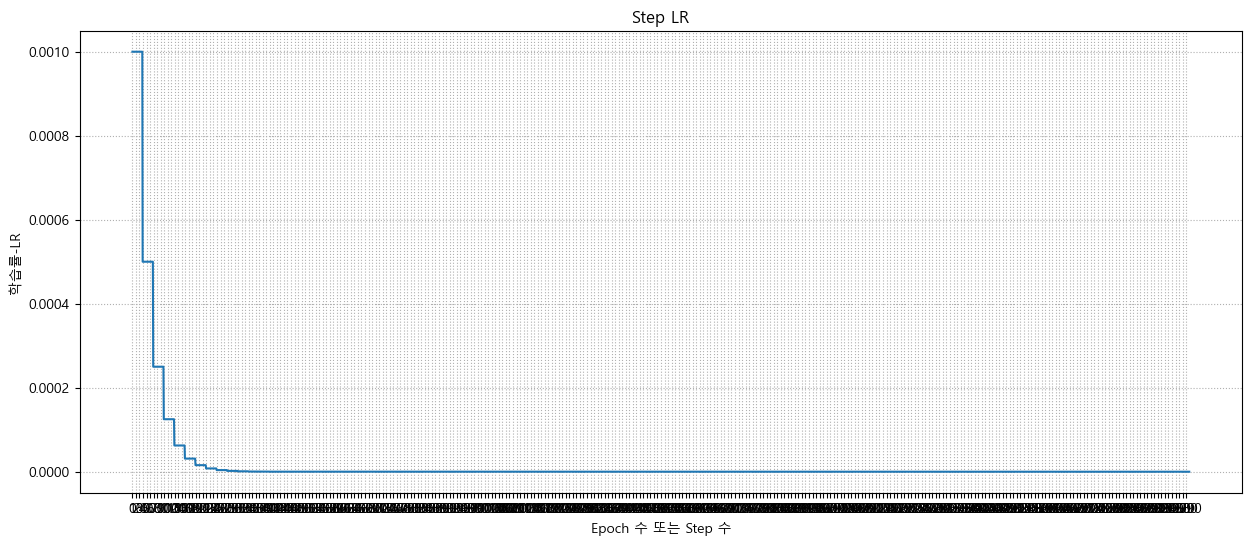

In [12]:
plt.rcParams['font.family'] = "malgun gothic"
plot_lr("Step LR", lr_list)

#### CosineAnnealingLR

cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.


In [13]:
optim = torch.optim.Adam(small_model.parameters(), lr=0.001)
ca_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim,
    T_max=10, # 변화 주기 (step 또는 epoch) - '최대(초기LR)~최소 또는 최소~최대'가 한 주기임.
    eta_min=1e-6, # lr 최소값 지정
)

In [14]:
lr_list = []
for epoch in range(epochs):
    for step in range(step_size):
        # ... 학습
        optim.step()
        optim.zero_grad()
    
    ca_lr_scheduler.step() # epoch 단위로 lr 변경 (epoch 10번 동안 lr값이 최대~최소로 움직인다.)
    lr_list.append(ca_lr_scheduler.get_last_lr())

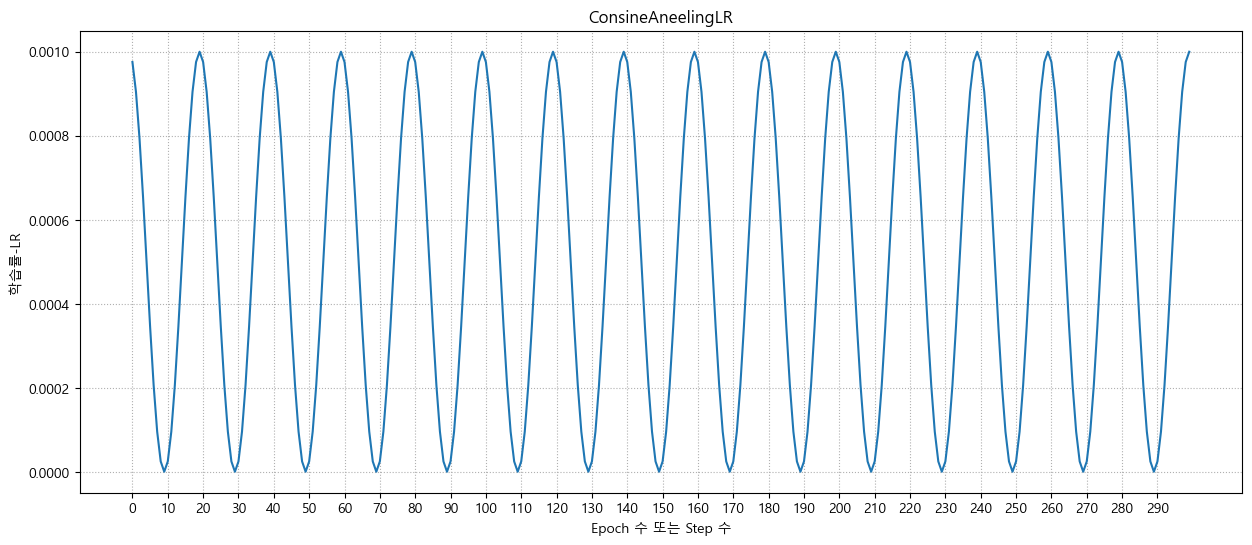

In [15]:
plot_lr("ConsineAneelingLR", lr_list)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)


In [ ]:
optim = torch.optim.Adam(small_model.parameters(), lr=0.001)
cawr_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optim,
    T_0=10, # 변화 주기 (위치에 따라 step 또는 epoch)
    T_mult=2, # 새로운 변화 주기(새로운 T_0) = 현재 T_0 * T_mult (한 주기가 끝날 때마다 T_0를 다시 계산)
    eta_min=1e-6
)

In [18]:
lr_list = []
for epoch in range(epochs):
    for step in range(step_size):
        # ... 학습
        optim.step()
        optim.zero_grad()
    
    cawr_lr_scheduler.step() # epoch 단위로 lr 변경 (10번 -> 20번 -> 40번 ...)
    lr_list.append(cawr_lr_scheduler.get_last_lr())

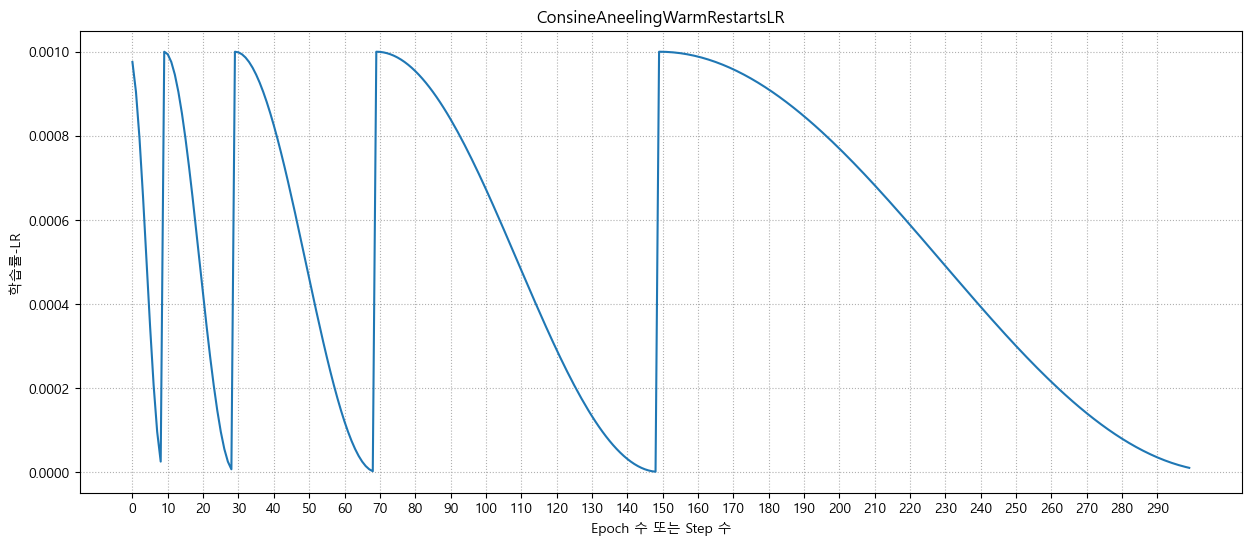

In [19]:
plot_lr("ConsineAneelingWarmRestartsLR", lr_list)